# Intro

[Codebook](http://start.umd.edu/gtd/downloads/Codebook.pdf)

## For prediction of conflictual zones intensities

0. Estimate global risque metric (function of #death, #injured, ...)

1. Look at points (zones) in space (Middle east) over all years.
2. Graph too dense, merge data to smaller clusters (look for technique to do it efficiently)
3. Plot evolution over time or current situatation
4. Fit model prediction (step = month ?)

[Stationary signal processing on graphs](https://arxiv.org/pdf/1601.02522.pdf)

[Predicting the evolution of stationary graph signals](https://arxiv.org/pdf/1607.03313.pdf)

[A GRAPH DOWNSAMPLING TECHNIQUE BASED On GRAPH FOURIER TRANSFORM](https://arxiv.org/pdf/1612.07542.pdf)

In [1]:
import pandas as pd
import os
import numpy as np

%matplotlib inline

In [2]:
data_path = 'data'
gtd_path = os.path.join(data_path, 'globalterrorismdb_0617dist.csv')

In [3]:
df = pd.read_csv(gtd_path, encoding='latin', usecols=['eventid', 'iyear', 'imonth', 'iday', 
            'extended', 'resolution', 'region', 'latitude', 'longitude'])

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.dtypes

eventid         int64
iyear           int64
imonth          int64
iday            int64
extended        int64
resolution     object
region          int64
latitude      float64
longitude     float64
dtype: object

In [5]:
df['region'].value_counts()

10    46511
6     41497
3     18762
8     16307
11    15491
5     11453
2     10340
9      5031
1      3346
4       794
7       554
12      264
Name: region, dtype: int64

In [6]:
df = df.dropna(subset=('longitude', 'latitude'))

In [7]:
len(df)

165744

In [8]:
df_ME = df[df['region'] == 10]
df_ME.loc[df_ME.imonth == 0, 'imonth'] = 1
df_ME.loc[df_ME.iday == 0, 'iday'] = 1

df_ME.loc[df_ME.iday == 0, 'iday'] 

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Series([], Name: iday, dtype: int64)

In [9]:
import datetime
def parse_date(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    if month == 0:
        month = 1
    if day == 0:
        day = 1
    try:
        date = datetime.date(year, month, day)
    except Exception as e:
        date = datetime.date(year, month, 1)
    return date
df_ME['date'] = df_ME.eventid.apply(parse_date)

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


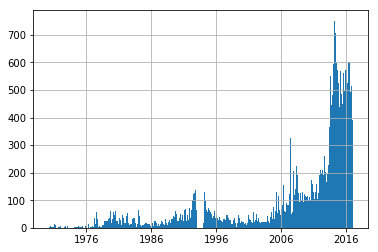

In [10]:
df_ME.date.hist(bins=45*12)

In [11]:
import folium

id_keep = np.random.permutation(np.arange(len(df_ME)))[:100]

mapit = folium.Map( location=[29.29, 42.55], zoom_start=4 )

for i, a in enumerate(df_ME.reset_index().loc[id_keep, ['latitude', 'longitude']].values):
    folium.Marker( location=[ a[0], a[1] ] ).add_to( mapit )
    if i%200 == 0:
        print(i)
mapit

0


In [36]:
from  pygsp.graphs.nngraphs.nngraph import NNGraph

# coords = df_ME[['latitude', 'longitude']].values
df_ME = df_ME.drop_duplicates(subset=('latitude', 'longitude'))
coords = df_ME[['latitude', 'longitude']].values

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import diags, coo_matrix

def knn_graph(cloud, k=30, mode='connectivity'):
    """
    Compute cloud graph. Use kNN to find nearest neig. and link points.

    Attributes:
        - cloud (array, Nx3): Point cloud expressed as [X | Y | Z] matrix of size Nx3
        - k (int): number of neig. to consider for kNN
        - dist3D: Use Z coordinate to compute distance between points whiule computing graph. If set to False, only XY values are
            considered.
        - mode (string): Can be either 'connectivity' or 'distance'. 'connectivity' will set weights to default values 1. 'distance'
            will set wiegths value as a function of w_ij = exp(dist_ij^2) / (2*s^2)), where s is the mean value of the distances
    Return:
        - W (sparse matrix, NxN): Weights graph matrix
    """

    # Copy cloud to avoid modifying base one
    cloud_res = np.array(cloud, copy=True)
    _k = k-1
            
    # Compute kNN and fit data
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(cloud_res) 
    dists, ids = nn.kneighbors(cloud_res)
    
    # Check construction mode
    rows, _ = np.indices(np.shape(ids))
    if mode == 'connectivity':
        w = np.ones(np.shape(dists))
    elif mode == 'distance':
        s = np.mean(dists[:,1:])
        w = np.exp(-np.power(dists,2)/(2*np.power(s,2)))
    else:
        return
    
    # Do not take base point (same point in knn)
    keep = np.array([id_!= i for i, id_ in enumerate(ids)])
    # Complete matrix according to positions
    _W = coo_matrix((w[keep].flatten(), (ids[keep].flatten(), rows[keep].flatten())), 
                       shape=(np.shape(dists)[0], np.shape(dists)[0]))

    _W = 1/2*(_W + _W.T)
    
    return _W

In [38]:
from pygsp import graphs

W_ME = knn_graph(coords, k=10)
G_ME = graphs.Graph(W_ME)


In [39]:
from pygsp.reduction import graph_multiresolution, graph_sparsify


In [ ]:
G2 = graph_sparsify(G_ME, 0.1)